In [ ]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation,GlobalAveragePooling2D


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

Cross Validation 70-30

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import shutil

# Ruta donde se encuentran tus archivos originales
source_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/training_set/normal'

# Rutas de destino para los conjuntos de prueba y validación
train_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_train/normal'
val_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_val/normal'

# Porcentaje de archivos que irán al conjunto de prueba
test_percent = 0.8

# Crear el directorio de prueba si no existe
if not os.path.exists(train_path):
    os.makedirs(train_path)

# Crear el directorio de validación si no existe
if not os.path.exists(val_path):
    os.makedirs(val_path)

# Listar todos los archivos en el directorio fuente
file_list = os.listdir(source_path)

# Calcular la cantidad de archivos para el conjunto de prueba y de validación
test_count = int(len(file_list) * test_percent)
val_count = len(file_list) - test_count

# Mezclar aleatoriamente la lista de archivos
random.shuffle(file_list)

# Mover archivos al conjunto de prueba
for file in file_list[:test_count]:
    source_file = os.path.join(source_path, file)
    dest_file = os.path.join(train_path, file)
    shutil.move(source_file, dest_file)

# Mover archivos al conjunto de validación
for file in file_list[test_count:test_count + val_count]:
    source_file = os.path.join(source_path, file)
    dest_file = os.path.join(val_path, file)
    shutil.move(source_file, dest_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import shutil

# Ruta donde se encuentran tus archivos originales
source_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/training_set/glaucoma'

# Rutas de destino para los conjuntos de prueba y validación
train_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_train/glaucoma'
val_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_val/glaucoma'

# Porcentaje de archivos que irán al conjunto de prueba
test_percent = 0.8

# Crear el directorio de prueba si no existe
if not os.path.exists(train_path):
    os.makedirs(train_path)

# Crear el directorio de validación si no existe
if not os.path.exists(val_path):
    os.makedirs(val_path)

# Listar todos los archivos en el directorio fuente
file_list = os.listdir(source_path)

# Calcular la cantidad de archivos para el conjunto de prueba y de validación
test_count = int(len(file_list) * test_percent)
val_count = len(file_list) - test_count

# Mezclar aleatoriamente la lista de archivos
random.shuffle(file_list)

# Mover archivos al conjunto de prueba
for file in file_list[:test_count]:
    source_file = os.path.join(source_path, file)
    dest_file = os.path.join(train_path, file)
    shutil.move(source_file, dest_file)

# Mover archivos al conjunto de validación
for file in file_list[test_count:test_count + val_count]:
    source_file = os.path.join(source_path, file)
    dest_file = os.path.join(val_path, file)
    shutil.move(source_file, dest_file)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_train'
test_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/test_set'
val_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_val'

Mounted at /content/drive


COnvertir la imagenes a pixels

normal


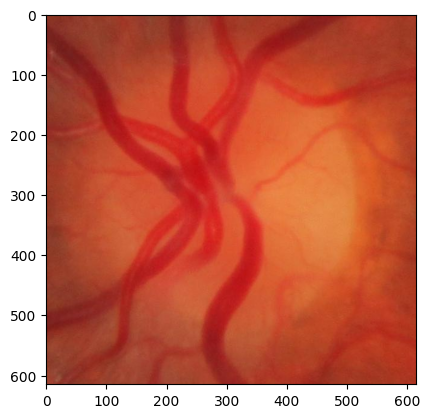

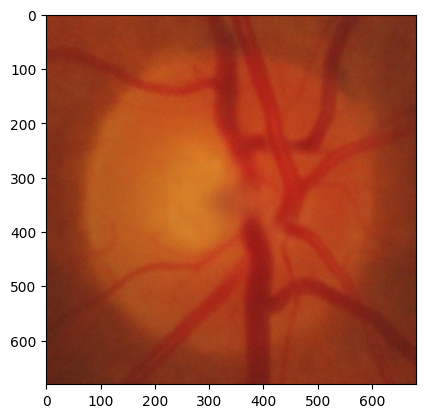

glaucoma


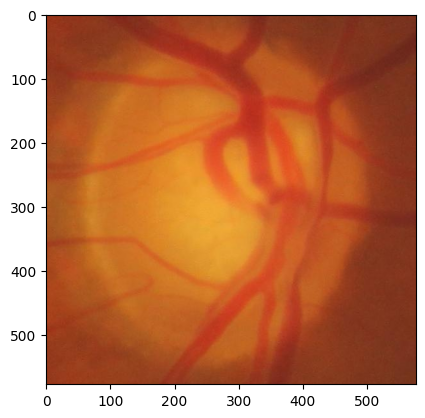

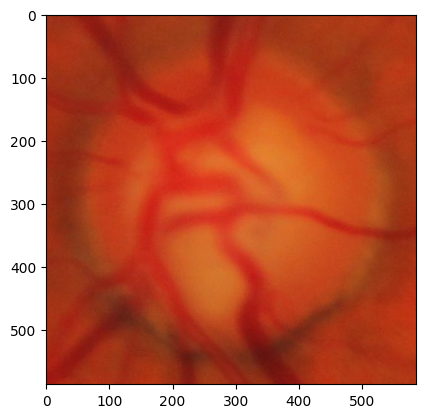

In [ ]:
for folder in os.listdir(train_path):
    sub_path = train_path + "/" + folder

    print(folder)
    for i in range(2):
        temp_path = os.listdir(sub_path)[i]
        temp_path = sub_path + "/" + temp_path
        img = mpimg.imread(temp_path)
        imgplot = plt.imshow(img)
        plt.show()

In [ ]:
def apply_augmentations(image, size):
    # Rotaciones aleatorias entre -30° y 30°
    angle = np.random.randint(-30, 31)
    M = cv2.getRotationMatrix2D((size[0] / 2, size[1] / 2), angle, 1)
    image = cv2.warpAffine(image, M, size)

    # Volteo horizontal aleatorio
    if np.random.random() > 0.5:
        image = cv2.flip(image, 1)

    # Volteo vertical aleatorio
    if np.random.random() > 0.5:
        image = cv2.flip(image, 0)

    # Zoom aleatorio entre 0.8 y 1.2
    zoom = np.random.uniform(0.8, 1.2)
    h, w, _ = image.shape
    new_h, new_w = int(h * zoom), int(w * zoom)
    image = cv2.resize(image, (new_w, new_h))

    return image

In [ ]:
def apply_mask(image, mask, mask_2, line_thickness=2):
    if image is not None and mask is not None and mask_2 is not None:
        # Asegurarse de que image, mask y mask_2 sean matrices de NumPy válidas
        if isinstance(image, np.ndarray) and isinstance(mask, np.ndarray) and isinstance(mask_2, np.ndarray):
            # Verificar si la imagen y las máscaras tienen el mismo tamaño
            if image.shape[:2] != mask.shape[:2]:
                # Redimensionar la máscara 1 para que tenga el mismo tamaño que la imagen
                mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

            if image.shape[:2] != mask_2.shape[:2]:
                # Redimensionar la máscara 2 para que tenga el mismo tamaño que la imagen
                mask_2 = cv2.resize(mask_2, (image.shape[1], image.shape[0]))

            # Asegurarse de que todas las matrices tengan el mismo tipo de dato (CV_8U)
            image = image.astype(np.uint8)
            mask = mask.astype(np.uint8)
            mask_2 = mask_2.astype(np.uint8)

            # Copia de la imagen original
            image_with_contour = image.copy()

            # PRIMERA MASCARA ---------------------------------------------------------------
            # Encuentra el contorno de la máscara 1
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Dibuja una línea roja alrededor del contorno de la máscara 1
            cv2.drawContours(image_with_contour, contours, -1, (0, 0, 255), line_thickness)

            # SEGUNDA MASCARA --------------------------------------------------------------
            # Encuentra el contorno de la máscara 2
            contours_2, _ = cv2.findContours(mask_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Crea una copia de la imagen con la primera máscara ya aplicada
            image_with_both_contours = image_with_contour.copy()

            # Dibuja una línea azul alrededor del contorno de la máscara 2
            cv2.drawContours(image_with_both_contours, contours_2, -1, (255, 0, 0), line_thickness)

            return image_with_both_contours
        else:
            print("image, mask y mask_2 deben ser matrices de NumPy válidas")
    else:
        print("image, mask o mask_2 es None, no se puede aplicar la máscara")



In [ ]:
def resize_image(image, size):
    return cv2.resize(image, size)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

mascara_glaucoma_path = '/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/RIM-ONE_segmentation/Glaucoma'
mascara_normal_path = '/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/RIM-ONE_segmentation/Normal'

def imagearray(path, size):
    data = []
    for folder in os.listdir(path):
        sub_path = os.path.join(path, folder)

        for img in os.listdir(sub_path):
            image_path = os.path.join(sub_path, img)
            img_name, img_extension = os.path.splitext(img)  # Separar el nombre del archivo y la extensión

            # Agregar "-Disc-T" al nombre del archivo y eliminar la extensión
            img_name_with_disc_t = img_name + "-1-Disc-T.png"
            img_name_with_cup_t = img_name + "-1-Cup-T.png"

            if img_name_with_disc_t in os.listdir(mascara_glaucoma_path) and img_name_with_cup_t in os.listdir(mascara_glaucoma_path):

                #mascara 1 Disco---------------------------------------
                path_glaucoma_mask = os.path.join(mascara_glaucoma_path, img_name_with_disc_t)

                # Cargar la imagen de máscara
                img_mask = cv2.imread(path_glaucoma_mask)

                # Cargar la máscara
                mascara = cv2.imread(path_glaucoma_mask, cv2.IMREAD_GRAYSCALE)

                #Masacara 2 Cup--------------------------------------
                path_glaucoma_mask_2_cup = os.path.join(mascara_glaucoma_path, img_name_with_cup_t)

                # Cargar la imagen de máscara
                img_mask_2_cup = cv2.imread(path_glaucoma_mask_2_cup)

                # Cargar la máscara
                mascara_2_cup = cv2.imread(path_glaucoma_mask_2_cup, cv2.IMREAD_GRAYSCALE)


                #--------------------------------------------------------------------------------------------
                if img_mask is not None and mascara is not None and mascara_2_cup is not None:
                    mascara = cv2.resize(mascara, size)
                    mascara_2_cup = cv2.resize(mascara_2_cup, size)
                    img_arr = cv2.imread(image_path)

                    if img_arr is not None:
                        img_arr = apply_mask(img_arr, mascara, mascara_2_cup)
                        img_arr = cv2.resize(img_arr, size)

                        # Aplicar las transformaciones a la imagen
                        img_arr = apply_augmentations(img_arr, size)


                        data.append(img_arr)
                    else:
                        print(f"Error al cargar la imagen: {image_path}")
                else:
                    print(f"Error al cargar la máscara: {path_glaucoma_mask}")
            else:
                if img_name_with_disc_t in os.listdir(mascara_normal_path) and img_name_with_cup_t in os.listdir(mascara_normal_path):
                     #mascara 1 Disco---------------------------------------
                  path_normal_mask = os.path.join(mascara_normal_path, img_name_with_disc_t)

                  # Cargar la imagen de máscara
                  img_mask = cv2.imread(path_normal_mask)

                  # Cargar la máscara
                  mascara = cv2.imread(path_normal_mask, cv2.IMREAD_GRAYSCALE)

                  #Masacara 2 Cup--------------------------------------
                  path_normal_mask_2_cup = os.path.join(mascara_normal_path, img_name_with_cup_t)

                  # Cargar la imagen de máscara
                  img_mask_2_cup = cv2.imread(path_normal_mask_2_cup)

                  # Cargar la máscara
                  mascara_2_cup = cv2.imread(path_normal_mask_2_cup, cv2.IMREAD_GRAYSCALE)


                  #--------------------------------------------------------------------------------------------
                  if img_mask is not None and mascara is not None and mascara_2_cup is not None:
                      mascara = cv2.resize(mascara, size)
                      mascara_2_cup = cv2.resize(mascara_2_cup, size)
                      img_arr = cv2.imread(image_path)

                      if img_arr is not None:
                          img_arr = apply_mask(img_arr, mascara, mascara_2_cup)
                          img_arr = cv2.resize(img_arr, size)

                          # Aplicar las transformaciones a la imagen
                          img_arr = apply_augmentations(img_arr, size)


                          data.append(img_arr)
                      else:
                          print(f"Error al cargar la imagen: {image_path}")
                  else:
                      print(f"Error al cargar la máscara: {path_normal_mask}")

    return data


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
size = (224,224)

train = imagearray(train_path, size)
test = imagearray(test_path, size)
val = imagearray(val_path, size)



train


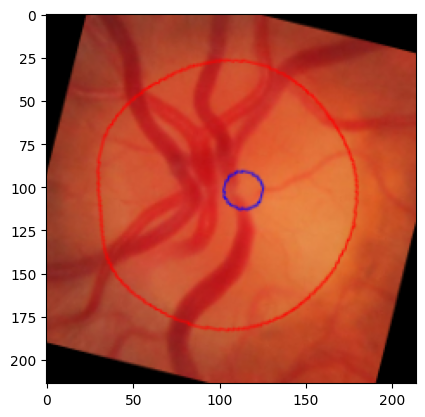

train


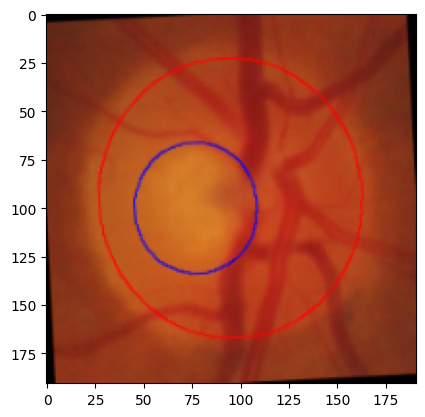

test


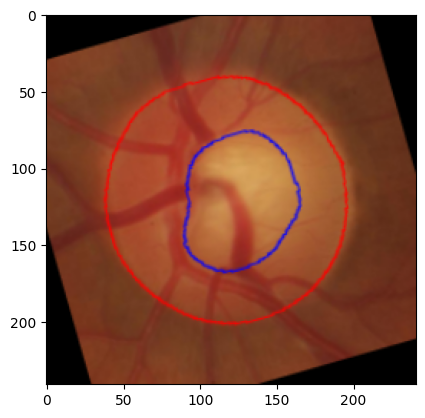

test


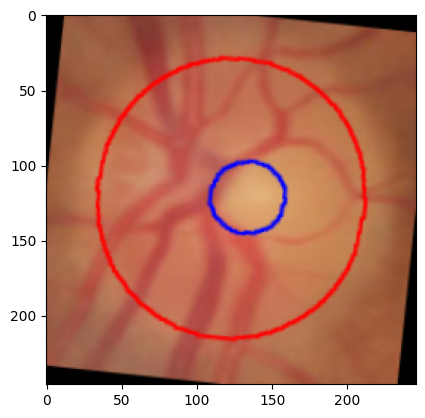

val


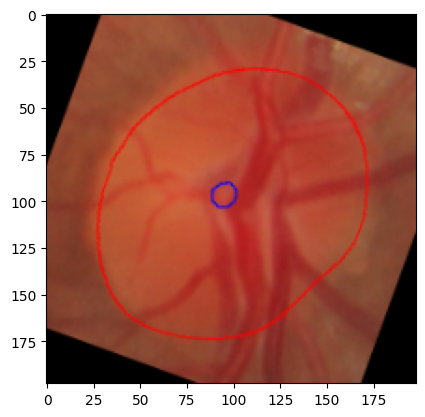

val


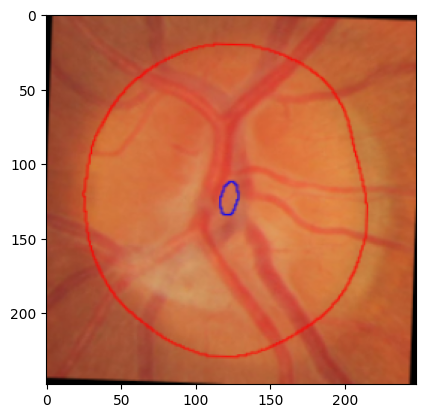

In [ ]:
for i in range(2):
    print("train")
    img_rgb = cv2.cvtColor(train[i], cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(img_rgb)
    plt.show()

for i in range(2):
    print("test")
    img_rgb = cv2.cvtColor(test[i], cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(img_rgb)
    plt.show()

for i in range(2):
    print("val")
    img_rgb = cv2.cvtColor(val[i], cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(img_rgb)
    plt.show()

Normalización

In [ ]:
def check_label_correspondence(data_path):
    label_counts = {}
    for root, dirs, files in os.walk(data_path):
        if len(files) > 0:
            label = os.path.basename(root)
            label_counts[label] = len(files)

    return label_counts

In [ ]:
label_counts = check_label_correspondence(train_path)
print(label_counts)

{'normal': 156, 'glaucoma': 92}


In [ ]:
size = (224, 224)  # Tamaño deseado para las imágenes

train = [cv2.resize(img, size) for img in train]
test = [cv2.resize(img, size) for img in test]
val = [cv2.resize(img, size) for img in val]

In [ ]:
x_train = np.array(train)
x_test = np.array(test)
x_val = np.array(val)

In [ ]:
x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0

In [ ]:
x_train.shape

(248, 224, 224, 3)

In [ ]:
def data_class(data_path, size, class_mode):
    datagen = ImageDataGenerator(rescale = 1./255)
    classes = datagen.flow_from_directory(data_path,
                                          target_size = size,
                                          batch_size = 64,
                                          class_mode = class_mode)
    return classes

In [ ]:
train_class = data_class(train_path, size, 'sparse')
test_class = data_class(test_path, size, 'sparse')
val_class = data_class(val_path, size, 'sparse')

Found 248 images belonging to 2 classes.
Found 174 images belonging to 2 classes.
Found 63 images belonging to 2 classes.


In [ ]:
y_train = train_class.classes
y_test = test_class.classes
y_val = val_class.classes

In [ ]:
train_class.class_indices

{'glaucoma': 0, 'normal': 1}

In [ ]:
y_train.shape,y_test.shape, y_val.shape

((248,), (174,), (63,))

In [ ]:
vgg = VGG19(input_shape = (224, 224, 3), pooling=GlobalAveragePooling2D,  include_top = False)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
vgg.trainable = True

In [ ]:
#inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
#x = vgg(inputs, training=True)
x = vgg.output
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(2, activation='softmax')(x)
model = keras.Model(inputs=vgg.input, outputs=outputs)

In [ ]:
model.load_weights('/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/vgg19_final_weights.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True

# x = Flatten()(model_vgg.output)
# prediction = Dense(1, activation='softmax')(x)

#model = Model(inputs=model_vgg.input, outputs=prediction)
model.summary()
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="Adagrad",
  metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

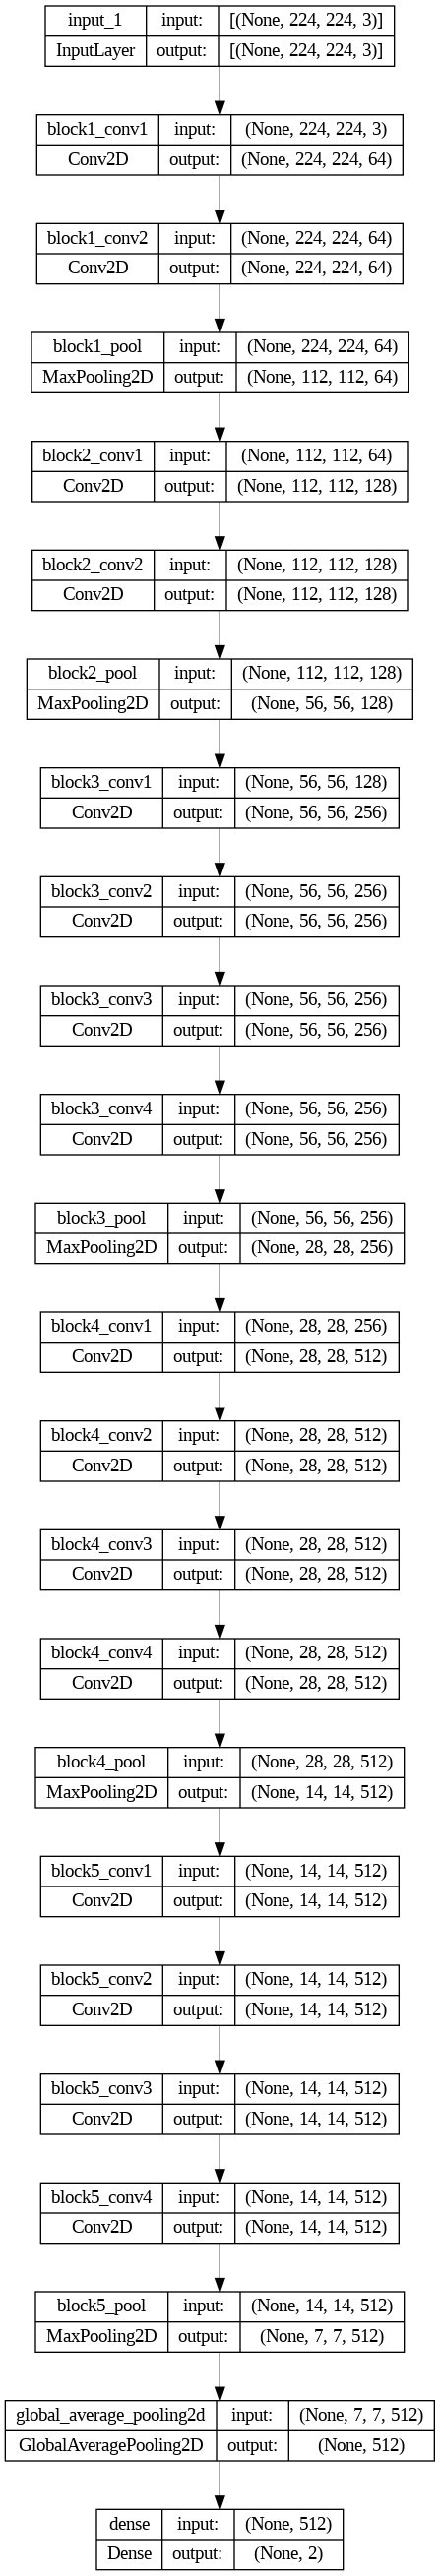

In [ ]:
plot_model(model=model, show_shapes=True)

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 7)

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=7)

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="Adagrad",
  metrics=['accuracy']
)

In [ ]:
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 15, callbacks=[early_stop], batch_size = 64, shuffle=True)

Epoch 1/15
4/4 [==============================] - 766s 195s/step - loss: 3.2512 - accuracy: 0.5081 - val_loss: 0.6830 - val_accuracy: 0.6190
Epoch 2/15
4/4 [==============================] - 776s 196s/step - loss: 0.6631 - accuracy: 0.6290 - val_loss: 0.6681 - val_accuracy: 0.6190
Epoch 3/15
4/4 [==============================] - 762s 196s/step - loss: 0.6625 - accuracy: 0.6290 - val_loss: 0.6666 - val_accuracy: 0.6190
Epoch 4/15
4/4 [==============================] - 760s 195s/step - loss: 0.6611 - accuracy: 0.6290 - val_loss: 0.6679 - val_accuracy: 0.6190
Epoch 5/15
4/4 [==============================] - 759s 195s/step - loss: 0.6613 - accuracy: 0.6290 - val_loss: 0.6661 - val_accuracy: 0.6190
Epoch 6/15
4/4 [==============================] - 732s 185s/step - loss: 0.6698 - accuracy: 0.6290 - val_loss: 0.6688 - val_accuracy: 0.6190
Epoch 7/15
4/4 [==============================] - 758s 195s/step - loss: 0.6627 - accuracy: 0.6290 - val_loss: 0.6641 - val_accuracy: 0.6190
Epoch 8/15
4/

Visualización

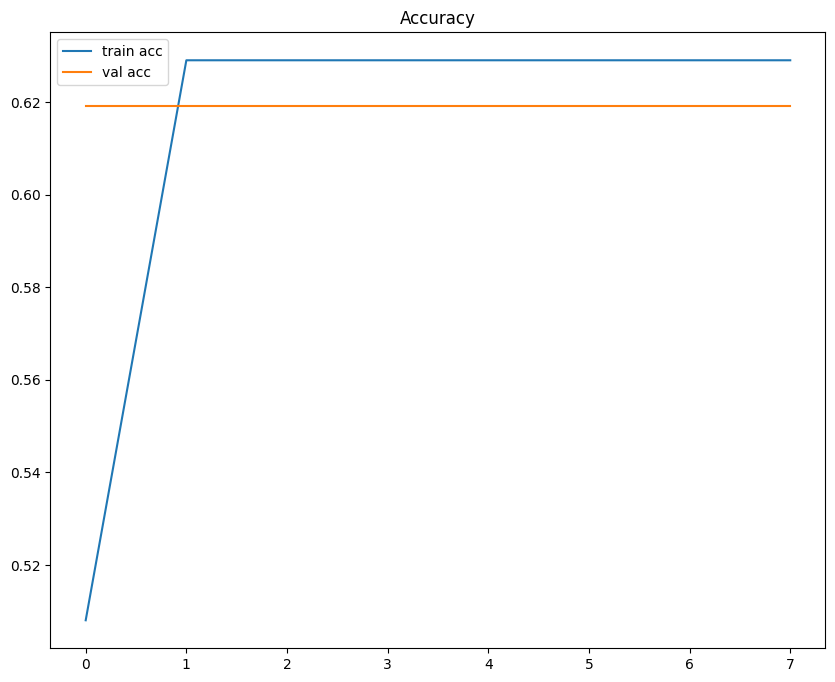

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

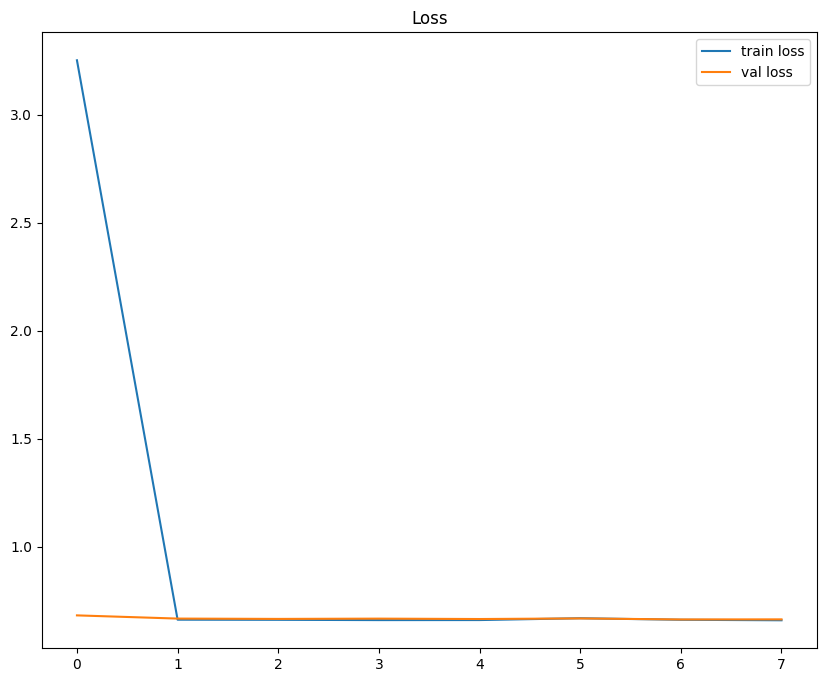

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

Evaluacion_Modelo

In [ ]:
model.evaluate(x_test, y_test, batch_size=64)

3/3 [==============================] - 143s 44s/step - loss: 0.6320 - accuracy: 0.6782


[0.6319859027862549, 0.6781609058380127]

In [ ]:
y_pred = model.predict(x_test)

6/6 [==============================] - 133s 22s/step


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.68      0.81       174

    accuracy                           0.68       174
   macro avg       0.50      0.34      0.40       174
weighted avg       1.00      0.68      0.81       174



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
precision_score(y_test, y_pred, average='micro')

0.6781609195402298

In [ ]:
f1_score(y_test, y_pred, average='micro')

0.6781609195402298

Eliminar los txt que nos da para la segmentacion y quedarnos solo con las imagenes

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Directorio en el que deseas eliminar los archivos .txt
directorio = '/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/RIM-ONE_segmentation/Normal'

# Itera sobre todos los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith('.txt'):
        archivo_completo = os.path.join(directorio, archivo)
        os.remove(archivo_completo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
